# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

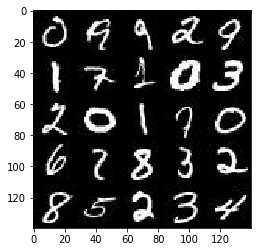

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

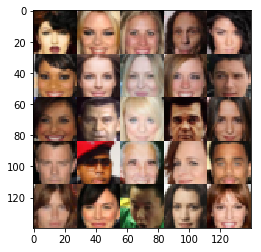

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height,image_channels), name='real_input')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='z_inputs')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha=0.2
    
    with tf.variable_scope('generator',reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
#         print(x1.shape)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now
#         print(x2.shape)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now
#         print(x3.shape)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3,out_channel_dim, 5, strides=2, padding='same')
        # 28x28xout_channel_dim now
#         print(logits.shape)
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    
#     d_train_opt = tf.train.AdamOptimizer(
#         learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
#     ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
#     g_updates = [opt for opt in ops if opt.name.startswith('generator')]
#     with tf.control_dependencies(g_updates):
#         g_train_opt = tf.train.AdamOptimizer(
#             learning_rate, beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [17]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
#     class GAN:
#         def __init__(self, data_shape, z_dim, beta1=0.5):
#             tf.reset_default_graph()

#             self.input_real, self.input_z, self.learning_rate = model_inputs(data_shape[0],\
#                                                                              data_shape[1],data_shape[2],z_dim)

#             self.d_loss, self.g_loss = model_loss(self.input_real,self.input_z,data_shape[2])

#             self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, self.learning_rate, beta1)
    
#     # Create the network
#     net = GAN(data_shape, z_dim, beta1=beta1)
    
#     saver = tf.train.Saver()
#     n_images = 72

# #     samples, losses = [], []
#     steps = 0

    _, img_width, img_height, img_channels = data_shape
    
    real_input, z_input, lr = model_inputs(
        img_width, img_height, img_channels, z_dim)
    
    d_loss, g_loss = model_loss(real_input, z_input, img_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    print_every = 10
    show_every = 100
    losses = []
    n_images = 25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0
                batch_z = np.random.uniform(-1, 1, (batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={
                        real_input: batch_images, z_input: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={
                        real_input: batch_images,z_input: batch_z, lr: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({z_input: batch_z, real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, z_input, img_channels, data_image_mode)
#                 steps += 1

#                 # Sample random noise for G
#                 batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
#                 # Run optimizers
#                 _ = sess.run(net.d_opt, feed_dict={net.input_real: batch_images,\
#                                                    net.input_z: batch_z,\
#                                                    net.learning_rate: learning_rate})
#                 _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z,\
#                                                    net.input_real: batch_images,\
#                                                   net.learning_rate: learning_rate})
# #                 if steps % 20 == 0:
# #                     # At the end of each epoch, get the losses and print them out
# #                     train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: batch_images})
# #                     train_loss_g = net.g_loss.eval({net.input_z: batch_z})

# #                     print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
# #                           "Discriminator Loss: {:.4f}...".format(train_loss_d),
# #                           "Generator Loss: {:.4f}".format(train_loss_g))
                    
#                 if steps % 100 == 0:
#                     show_generator_output(sess, n_images, net.input_z, data_shape[2], data_image_mode)


### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 1/2... Discriminator Loss: 0.1671... Generator Loss: 3.2693
Epoch 1/2... Discriminator Loss: 0.1554... Generator Loss: 2.5559
Epoch 1/2... Discriminator Loss: 0.0728... Generator Loss: 6.1398
Epoch 1/2... Discriminator Loss: 0.5821... Generator Loss: 12.2837
Epoch 1/2... Discriminator Loss: 0.2076... Generator Loss: 2.3102
Epoch 1/2... Discriminator Loss: 0.0775... Generator Loss: 3.6669
Epoch 1/2... Discriminator Loss: 1.5184... Generator Loss: 8.5228
Epoch 1/2... Discriminator Loss: 2.4501... Generator Loss: 6.2039
Epoch 1/2... Discriminator Loss: 0.1927... Generator Loss: 2.6253
Epoch 1/2... Discriminator Loss: 0.3414... Generator Loss: 2.2078


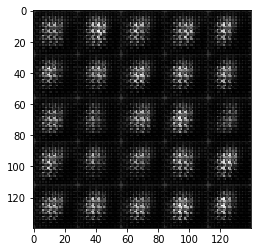

Epoch 1/2... Discriminator Loss: 0.7558... Generator Loss: 3.0653
Epoch 1/2... Discriminator Loss: 0.2972... Generator Loss: 2.0927
Epoch 1/2... Discriminator Loss: 0.2970... Generator Loss: 2.5326
Epoch 1/2... Discriminator Loss: 0.2029... Generator Loss: 2.5953
Epoch 1/2... Discriminator Loss: 0.5541... Generator Loss: 2.2892
Epoch 1/2... Discriminator Loss: 0.4218... Generator Loss: 3.6082
Epoch 1/2... Discriminator Loss: 0.4255... Generator Loss: 2.0384
Epoch 1/2... Discriminator Loss: 0.6080... Generator Loss: 1.7171
Epoch 1/2... Discriminator Loss: 1.0009... Generator Loss: 1.6212
Epoch 1/2... Discriminator Loss: 0.5693... Generator Loss: 1.9052


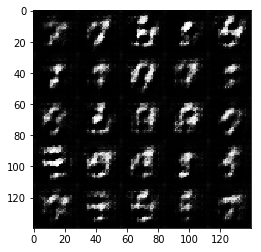

Epoch 1/2... Discriminator Loss: 1.0358... Generator Loss: 2.7597
Epoch 1/2... Discriminator Loss: 2.0409... Generator Loss: 0.2062
Epoch 1/2... Discriminator Loss: 0.6574... Generator Loss: 1.8873
Epoch 1/2... Discriminator Loss: 0.6519... Generator Loss: 1.2312
Epoch 1/2... Discriminator Loss: 0.6997... Generator Loss: 1.7187
Epoch 1/2... Discriminator Loss: 0.8713... Generator Loss: 1.8747
Epoch 1/2... Discriminator Loss: 0.7339... Generator Loss: 2.1516
Epoch 1/2... Discriminator Loss: 0.9847... Generator Loss: 0.7884
Epoch 1/2... Discriminator Loss: 0.7306... Generator Loss: 1.1138
Epoch 1/2... Discriminator Loss: 0.6179... Generator Loss: 1.4953


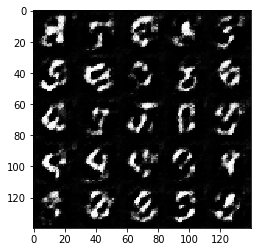

Epoch 1/2... Discriminator Loss: 1.0612... Generator Loss: 1.5939
Epoch 1/2... Discriminator Loss: 0.7361... Generator Loss: 1.4352
Epoch 1/2... Discriminator Loss: 0.7480... Generator Loss: 1.3545
Epoch 1/2... Discriminator Loss: 0.7962... Generator Loss: 1.1049
Epoch 1/2... Discriminator Loss: 1.2951... Generator Loss: 0.4718
Epoch 1/2... Discriminator Loss: 1.0093... Generator Loss: 0.8213
Epoch 1/2... Discriminator Loss: 0.9472... Generator Loss: 0.9239
Epoch 1/2... Discriminator Loss: 0.8315... Generator Loss: 1.2173
Epoch 1/2... Discriminator Loss: 0.7820... Generator Loss: 1.3789
Epoch 1/2... Discriminator Loss: 1.3647... Generator Loss: 0.3929


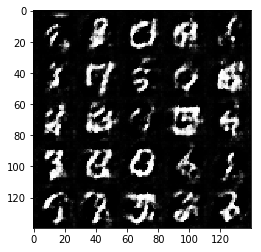

Epoch 1/2... Discriminator Loss: 0.9024... Generator Loss: 1.0511
Epoch 1/2... Discriminator Loss: 0.9765... Generator Loss: 0.6910
Epoch 1/2... Discriminator Loss: 0.8288... Generator Loss: 0.9332
Epoch 1/2... Discriminator Loss: 0.7976... Generator Loss: 1.2375
Epoch 1/2... Discriminator Loss: 1.2603... Generator Loss: 0.4803
Epoch 1/2... Discriminator Loss: 0.7568... Generator Loss: 1.0095
Epoch 2/2... Discriminator Loss: 0.8523... Generator Loss: 1.8540
Epoch 2/2... Discriminator Loss: 0.7245... Generator Loss: 1.2117
Epoch 2/2... Discriminator Loss: 0.7955... Generator Loss: 1.5005
Epoch 2/2... Discriminator Loss: 0.7949... Generator Loss: 1.2481


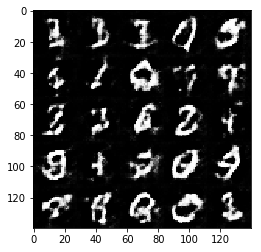

Epoch 2/2... Discriminator Loss: 0.8952... Generator Loss: 0.8055
Epoch 2/2... Discriminator Loss: 0.6382... Generator Loss: 1.2987
Epoch 2/2... Discriminator Loss: 0.8398... Generator Loss: 2.2547
Epoch 2/2... Discriminator Loss: 0.9403... Generator Loss: 0.7770
Epoch 2/2... Discriminator Loss: 0.8012... Generator Loss: 1.1412
Epoch 2/2... Discriminator Loss: 1.0895... Generator Loss: 0.5773
Epoch 2/2... Discriminator Loss: 0.7373... Generator Loss: 1.4562
Epoch 2/2... Discriminator Loss: 0.8997... Generator Loss: 0.7909
Epoch 2/2... Discriminator Loss: 1.0092... Generator Loss: 1.6030
Epoch 2/2... Discriminator Loss: 0.9261... Generator Loss: 0.7217


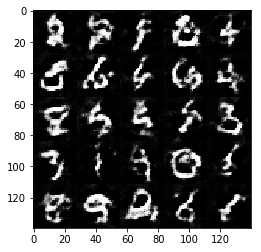

Epoch 2/2... Discriminator Loss: 1.0547... Generator Loss: 2.3362
Epoch 2/2... Discriminator Loss: 1.0103... Generator Loss: 1.6814
Epoch 2/2... Discriminator Loss: 0.8608... Generator Loss: 1.5312
Epoch 2/2... Discriminator Loss: 0.8831... Generator Loss: 1.5819
Epoch 2/2... Discriminator Loss: 0.8780... Generator Loss: 1.8299
Epoch 2/2... Discriminator Loss: 0.8186... Generator Loss: 1.5872
Epoch 2/2... Discriminator Loss: 0.7876... Generator Loss: 1.6509
Epoch 2/2... Discriminator Loss: 0.9769... Generator Loss: 2.1806
Epoch 2/2... Discriminator Loss: 1.0521... Generator Loss: 0.6093
Epoch 2/2... Discriminator Loss: 0.8471... Generator Loss: 1.7229


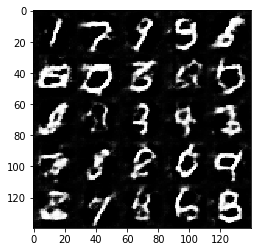

Epoch 2/2... Discriminator Loss: 0.7525... Generator Loss: 1.3086
Epoch 2/2... Discriminator Loss: 0.8008... Generator Loss: 0.8974
Epoch 2/2... Discriminator Loss: 0.7883... Generator Loss: 1.5954
Epoch 2/2... Discriminator Loss: 1.1837... Generator Loss: 2.4632
Epoch 2/2... Discriminator Loss: 1.0016... Generator Loss: 0.6553
Epoch 2/2... Discriminator Loss: 1.0903... Generator Loss: 2.1088
Epoch 2/2... Discriminator Loss: 0.7821... Generator Loss: 1.1275
Epoch 2/2... Discriminator Loss: 0.8689... Generator Loss: 1.5276
Epoch 2/2... Discriminator Loss: 0.9494... Generator Loss: 2.0914
Epoch 2/2... Discriminator Loss: 0.8665... Generator Loss: 1.7342


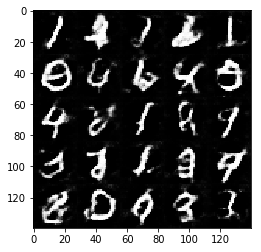

Epoch 2/2... Discriminator Loss: 0.7563... Generator Loss: 1.4280
Epoch 2/2... Discriminator Loss: 0.9648... Generator Loss: 0.6872
Epoch 2/2... Discriminator Loss: 0.7318... Generator Loss: 1.2762
Epoch 2/2... Discriminator Loss: 0.9305... Generator Loss: 0.7516
Epoch 2/2... Discriminator Loss: 1.0500... Generator Loss: 0.5859
Epoch 2/2... Discriminator Loss: 0.7224... Generator Loss: 1.2297
Epoch 2/2... Discriminator Loss: 0.8963... Generator Loss: 1.6939
Epoch 2/2... Discriminator Loss: 1.0571... Generator Loss: 0.5446
Epoch 2/2... Discriminator Loss: 0.7918... Generator Loss: 0.8734
Epoch 2/2... Discriminator Loss: 0.6988... Generator Loss: 1.3052


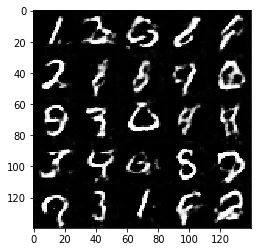

Epoch 2/2... Discriminator Loss: 0.8194... Generator Loss: 1.7007
Epoch 2/2... Discriminator Loss: 0.7492... Generator Loss: 0.9390
Epoch 2/2... Discriminator Loss: 0.7619... Generator Loss: 1.6186


In [18]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

In [19]:
mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
mnist_dataset.shape

(60000, 28, 28, 1)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 1/1... Discriminator Loss: 0.9626... Generator Loss: 0.6877
Epoch 1/1... Discriminator Loss: 0.1552... Generator Loss: 7.4080
Epoch 1/1... Discriminator Loss: 0.2659... Generator Loss: 8.3428
Epoch 1/1... Discriminator Loss: 0.0255... Generator Loss: 4.8064
Epoch 1/1... Discriminator Loss: 0.0163... Generator Loss: 14.0038
Epoch 1/1... Discriminator Loss: 0.0864... Generator Loss: 6.5996
Epoch 1/1... Discriminator Loss: 0.5230... Generator Loss: 1.8694
Epoch 1/1... Discriminator Loss: 0.2243... Generator Loss: 2.9131
Epoch 1/1... Discriminator Loss: 2.3272... Generator Loss: 0.2173
Epoch 1/1... Discriminator Loss: 0.1268... Generator Loss: 5.3098


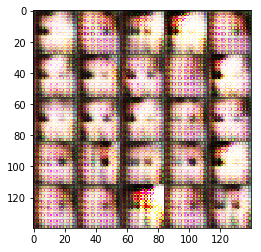

Epoch 1/1... Discriminator Loss: 0.4842... Generator Loss: 2.0403
Epoch 1/1... Discriminator Loss: 0.3167... Generator Loss: 3.0410
Epoch 1/1... Discriminator Loss: 0.5458... Generator Loss: 1.4039
Epoch 1/1... Discriminator Loss: 0.2609... Generator Loss: 2.4061
Epoch 1/1... Discriminator Loss: 0.3556... Generator Loss: 1.9184
Epoch 1/1... Discriminator Loss: 0.3952... Generator Loss: 1.7992
Epoch 1/1... Discriminator Loss: 0.2540... Generator Loss: 2.5759
Epoch 1/1... Discriminator Loss: 0.0251... Generator Loss: 5.0689
Epoch 1/1... Discriminator Loss: 0.1199... Generator Loss: 4.2621
Epoch 1/1... Discriminator Loss: 0.7579... Generator Loss: 1.8654


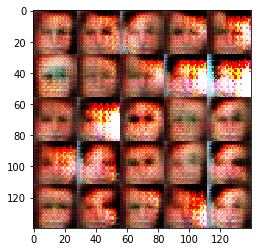

Epoch 1/1... Discriminator Loss: 0.9933... Generator Loss: 1.1957
Epoch 1/1... Discriminator Loss: 0.2454... Generator Loss: 2.6922
Epoch 1/1... Discriminator Loss: 0.6958... Generator Loss: 1.0856
Epoch 1/1... Discriminator Loss: 0.9432... Generator Loss: 2.0075
Epoch 1/1... Discriminator Loss: 3.0764... Generator Loss: 0.0743
Epoch 1/1... Discriminator Loss: 1.0674... Generator Loss: 0.7472
Epoch 1/1... Discriminator Loss: 3.7450... Generator Loss: 0.0450
Epoch 1/1... Discriminator Loss: 0.9829... Generator Loss: 0.7870
Epoch 1/1... Discriminator Loss: 0.8478... Generator Loss: 0.7343
Epoch 1/1... Discriminator Loss: 1.2053... Generator Loss: 0.5102


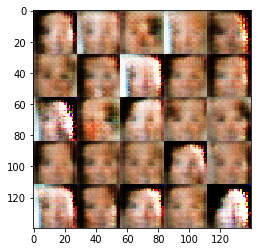

Epoch 1/1... Discriminator Loss: 0.5418... Generator Loss: 1.3005
Epoch 1/1... Discriminator Loss: 0.8837... Generator Loss: 2.0717
Epoch 1/1... Discriminator Loss: 0.4353... Generator Loss: 1.4593
Epoch 1/1... Discriminator Loss: 1.1247... Generator Loss: 0.6029
Epoch 1/1... Discriminator Loss: 0.7403... Generator Loss: 1.5989
Epoch 1/1... Discriminator Loss: 2.7996... Generator Loss: 4.0468
Epoch 1/1... Discriminator Loss: 0.7850... Generator Loss: 1.2804
Epoch 1/1... Discriminator Loss: 1.2299... Generator Loss: 1.0312
Epoch 1/1... Discriminator Loss: 1.4960... Generator Loss: 0.3651
Epoch 1/1... Discriminator Loss: 0.9649... Generator Loss: 1.3285


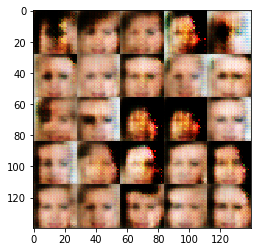

Epoch 1/1... Discriminator Loss: 1.1125... Generator Loss: 1.4246
Epoch 1/1... Discriminator Loss: 1.2911... Generator Loss: 2.2773
Epoch 1/1... Discriminator Loss: 0.7124... Generator Loss: 1.3179
Epoch 1/1... Discriminator Loss: 1.2991... Generator Loss: 2.1251
Epoch 1/1... Discriminator Loss: 0.5750... Generator Loss: 1.3191
Epoch 1/1... Discriminator Loss: 1.2422... Generator Loss: 1.6460
Epoch 1/1... Discriminator Loss: 0.1028... Generator Loss: 3.6846
Epoch 1/1... Discriminator Loss: 0.2102... Generator Loss: 1.9209
Epoch 1/1... Discriminator Loss: 0.1322... Generator Loss: 3.1401
Epoch 1/1... Discriminator Loss: 1.3547... Generator Loss: 2.9518


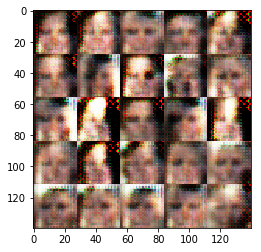

Epoch 1/1... Discriminator Loss: 0.8353... Generator Loss: 1.2153
Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 2.2677
Epoch 1/1... Discriminator Loss: 0.7249... Generator Loss: 1.9076
Epoch 1/1... Discriminator Loss: 0.9571... Generator Loss: 0.6448
Epoch 1/1... Discriminator Loss: 1.6569... Generator Loss: 2.8878
Epoch 1/1... Discriminator Loss: 0.3676... Generator Loss: 1.5335
Epoch 1/1... Discriminator Loss: 1.0425... Generator Loss: 1.5386
Epoch 1/1... Discriminator Loss: 1.3105... Generator Loss: 0.4286
Epoch 1/1... Discriminator Loss: 1.0426... Generator Loss: 0.9032
Epoch 1/1... Discriminator Loss: 0.6631... Generator Loss: 1.6154


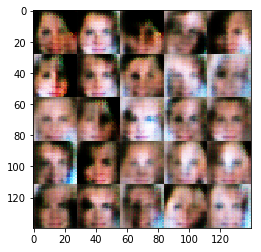

Epoch 1/1... Discriminator Loss: 0.6046... Generator Loss: 1.9123
Epoch 1/1... Discriminator Loss: 0.5739... Generator Loss: 1.6355
Epoch 1/1... Discriminator Loss: 1.6983... Generator Loss: 4.7395
Epoch 1/1... Discriminator Loss: 0.7354... Generator Loss: 1.0594
Epoch 1/1... Discriminator Loss: 0.6809... Generator Loss: 1.1890
Epoch 1/1... Discriminator Loss: 0.8335... Generator Loss: 1.9340
Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.7785
Epoch 1/1... Discriminator Loss: 0.8420... Generator Loss: 1.0492
Epoch 1/1... Discriminator Loss: 0.5218... Generator Loss: 1.2896
Epoch 1/1... Discriminator Loss: 1.0526... Generator Loss: 0.5082


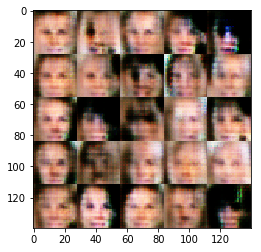

Epoch 1/1... Discriminator Loss: 0.3871... Generator Loss: 1.5777
Epoch 1/1... Discriminator Loss: 1.1551... Generator Loss: 0.5335
Epoch 1/1... Discriminator Loss: 0.0920... Generator Loss: 3.5776
Epoch 1/1... Discriminator Loss: 0.6440... Generator Loss: 1.8061
Epoch 1/1... Discriminator Loss: 4.1853... Generator Loss: 6.4407
Epoch 1/1... Discriminator Loss: 0.5361... Generator Loss: 1.3918
Epoch 1/1... Discriminator Loss: 0.4437... Generator Loss: 4.5192
Epoch 1/1... Discriminator Loss: 0.9809... Generator Loss: 0.8450
Epoch 1/1... Discriminator Loss: 0.5604... Generator Loss: 1.6047
Epoch 1/1... Discriminator Loss: 2.9015... Generator Loss: 5.1097


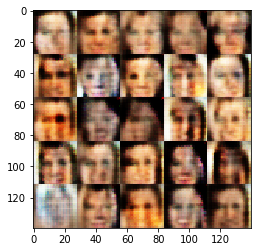

Epoch 1/1... Discriminator Loss: 0.6302... Generator Loss: 1.4395
Epoch 1/1... Discriminator Loss: 0.3434... Generator Loss: 1.7357
Epoch 1/1... Discriminator Loss: 0.3947... Generator Loss: 1.3018
Epoch 1/1... Discriminator Loss: 0.0643... Generator Loss: 3.4046
Epoch 1/1... Discriminator Loss: 0.0771... Generator Loss: 3.2146
Epoch 1/1... Discriminator Loss: 4.9772... Generator Loss: 5.7972
Epoch 1/1... Discriminator Loss: 1.2022... Generator Loss: 0.5115
Epoch 1/1... Discriminator Loss: 0.4223... Generator Loss: 1.9355
Epoch 1/1... Discriminator Loss: 0.6416... Generator Loss: 1.1549
Epoch 1/1... Discriminator Loss: 0.9560... Generator Loss: 0.6447


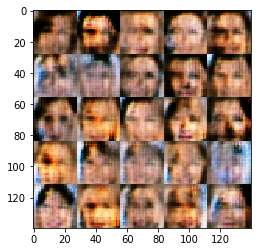

Epoch 1/1... Discriminator Loss: 0.6408... Generator Loss: 2.4234
Epoch 1/1... Discriminator Loss: 0.7396... Generator Loss: 0.9307
Epoch 1/1... Discriminator Loss: 1.1608... Generator Loss: 0.6256
Epoch 1/1... Discriminator Loss: 0.5049... Generator Loss: 2.8434
Epoch 1/1... Discriminator Loss: 0.4828... Generator Loss: 1.1594
Epoch 1/1... Discriminator Loss: 0.7661... Generator Loss: 1.0425
Epoch 1/1... Discriminator Loss: 0.2835... Generator Loss: 6.5866
Epoch 1/1... Discriminator Loss: 0.7443... Generator Loss: 1.7819
Epoch 1/1... Discriminator Loss: 1.0121... Generator Loss: 0.6662
Epoch 1/1... Discriminator Loss: 1.2998... Generator Loss: 3.7218


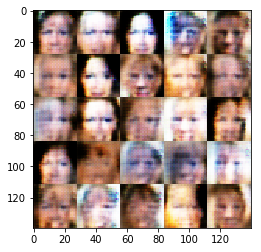

Epoch 1/1... Discriminator Loss: 0.2925... Generator Loss: 1.7918
Epoch 1/1... Discriminator Loss: 0.5363... Generator Loss: 1.3450
Epoch 1/1... Discriminator Loss: 0.5872... Generator Loss: 1.2063
Epoch 1/1... Discriminator Loss: 0.2596... Generator Loss: 2.1478
Epoch 1/1... Discriminator Loss: 0.0933... Generator Loss: 2.9604
Epoch 1/1... Discriminator Loss: 0.0192... Generator Loss: 7.0999
Epoch 1/1... Discriminator Loss: 1.0224... Generator Loss: 1.0456
Epoch 1/1... Discriminator Loss: 0.8237... Generator Loss: 2.4610
Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.4775
Epoch 1/1... Discriminator Loss: 0.6837... Generator Loss: 1.2355


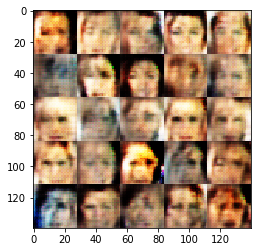

Epoch 1/1... Discriminator Loss: 0.9664... Generator Loss: 0.7304
Epoch 1/1... Discriminator Loss: 2.3842... Generator Loss: 0.1855
Epoch 1/1... Discriminator Loss: 0.8004... Generator Loss: 0.8632
Epoch 1/1... Discriminator Loss: 0.3927... Generator Loss: 2.1356
Epoch 1/1... Discriminator Loss: 0.8266... Generator Loss: 1.5398
Epoch 1/1... Discriminator Loss: 1.3620... Generator Loss: 3.7078
Epoch 1/1... Discriminator Loss: 0.3244... Generator Loss: 1.9141
Epoch 1/1... Discriminator Loss: 0.7619... Generator Loss: 1.0520
Epoch 1/1... Discriminator Loss: 0.4709... Generator Loss: 1.9372
Epoch 1/1... Discriminator Loss: 0.8685... Generator Loss: 0.8559


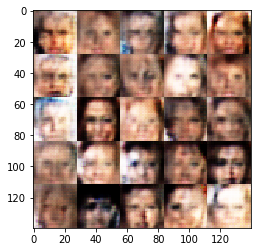

Epoch 1/1... Discriminator Loss: 0.6881... Generator Loss: 1.1175
Epoch 1/1... Discriminator Loss: 1.2235... Generator Loss: 3.4854
Epoch 1/1... Discriminator Loss: 0.6796... Generator Loss: 1.8444
Epoch 1/1... Discriminator Loss: 1.7618... Generator Loss: 0.2858
Epoch 1/1... Discriminator Loss: 0.8901... Generator Loss: 0.9009
Epoch 1/1... Discriminator Loss: 3.9065... Generator Loss: 0.0418
Epoch 1/1... Discriminator Loss: 0.8298... Generator Loss: 1.7461
Epoch 1/1... Discriminator Loss: 0.0872... Generator Loss: 3.1650
Epoch 1/1... Discriminator Loss: 0.2903... Generator Loss: 3.4443
Epoch 1/1... Discriminator Loss: 0.3661... Generator Loss: 1.9952


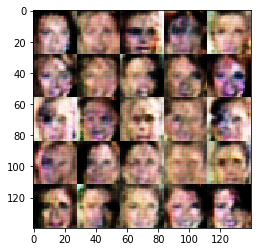

Epoch 1/1... Discriminator Loss: 0.0544... Generator Loss: 5.4127
Epoch 1/1... Discriminator Loss: 0.0478... Generator Loss: 4.5481
Epoch 1/1... Discriminator Loss: 0.3323... Generator Loss: 4.9465
Epoch 1/1... Discriminator Loss: 1.1640... Generator Loss: 0.5705
Epoch 1/1... Discriminator Loss: 0.7487... Generator Loss: 1.1505
Epoch 1/1... Discriminator Loss: 0.3342... Generator Loss: 2.1027
Epoch 1/1... Discriminator Loss: 0.5078... Generator Loss: 1.2890
Epoch 1/1... Discriminator Loss: 0.6510... Generator Loss: 1.3887
Epoch 1/1... Discriminator Loss: 1.1629... Generator Loss: 4.2192
Epoch 1/1... Discriminator Loss: 0.8357... Generator Loss: 0.7896


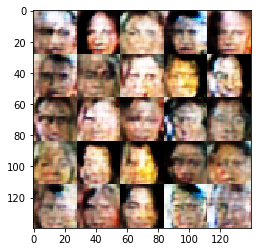

Epoch 1/1... Discriminator Loss: 2.1694... Generator Loss: 0.1914
Epoch 1/1... Discriminator Loss: 1.3792... Generator Loss: 0.4882
Epoch 1/1... Discriminator Loss: 0.8630... Generator Loss: 3.9989
Epoch 1/1... Discriminator Loss: 2.1276... Generator Loss: 4.7174
Epoch 1/1... Discriminator Loss: 0.3442... Generator Loss: 3.9438
Epoch 1/1... Discriminator Loss: 0.0947... Generator Loss: 3.4380
Epoch 1/1... Discriminator Loss: 1.7236... Generator Loss: 0.4420
Epoch 1/1... Discriminator Loss: 0.4069... Generator Loss: 2.3559
Epoch 1/1... Discriminator Loss: 1.1381... Generator Loss: 0.5982
Epoch 1/1... Discriminator Loss: 0.6170... Generator Loss: 1.3474


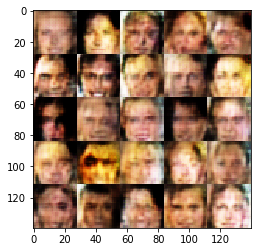

Epoch 1/1... Discriminator Loss: 1.1369... Generator Loss: 3.9431
Epoch 1/1... Discriminator Loss: 0.2277... Generator Loss: 2.4887
Epoch 1/1... Discriminator Loss: 0.5663... Generator Loss: 1.2113
Epoch 1/1... Discriminator Loss: 0.4931... Generator Loss: 3.0619
Epoch 1/1... Discriminator Loss: 0.3457... Generator Loss: 2.0555
Epoch 1/1... Discriminator Loss: 0.4954... Generator Loss: 1.4462
Epoch 1/1... Discriminator Loss: 0.5840... Generator Loss: 1.8283
Epoch 1/1... Discriminator Loss: 0.6468... Generator Loss: 1.2915
Epoch 1/1... Discriminator Loss: 0.2568... Generator Loss: 1.8321
Epoch 1/1... Discriminator Loss: 0.1912... Generator Loss: 3.3942


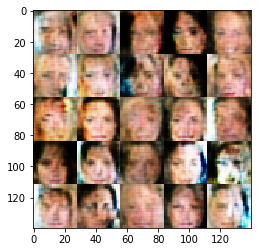

Epoch 1/1... Discriminator Loss: 3.2134... Generator Loss: 0.1282
Epoch 1/1... Discriminator Loss: 2.9384... Generator Loss: 5.1381
Epoch 1/1... Discriminator Loss: 0.7145... Generator Loss: 1.3392
Epoch 1/1... Discriminator Loss: 0.6483... Generator Loss: 1.1112
Epoch 1/1... Discriminator Loss: 1.3710... Generator Loss: 0.4887
Epoch 1/1... Discriminator Loss: 0.6509... Generator Loss: 3.4253
Epoch 1/1... Discriminator Loss: 0.4623... Generator Loss: 1.6122
Epoch 1/1... Discriminator Loss: 1.0215... Generator Loss: 0.7493
Epoch 1/1... Discriminator Loss: 1.7691... Generator Loss: 4.0971
Epoch 1/1... Discriminator Loss: 0.6135... Generator Loss: 1.1748


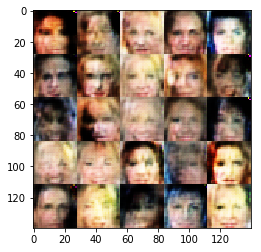

Epoch 1/1... Discriminator Loss: 0.4365... Generator Loss: 3.9792
Epoch 1/1... Discriminator Loss: 0.3516... Generator Loss: 1.6903
Epoch 1/1... Discriminator Loss: 0.3197... Generator Loss: 2.2131
Epoch 1/1... Discriminator Loss: 0.2630... Generator Loss: 2.3175
Epoch 1/1... Discriminator Loss: 0.1078... Generator Loss: 3.2899
Epoch 1/1... Discriminator Loss: 3.2628... Generator Loss: 4.4695
Epoch 1/1... Discriminator Loss: 0.8691... Generator Loss: 1.2548
Epoch 1/1... Discriminator Loss: 0.8253... Generator Loss: 1.8592
Epoch 1/1... Discriminator Loss: 0.9465... Generator Loss: 0.7136
Epoch 1/1... Discriminator Loss: 0.2689... Generator Loss: 2.2893


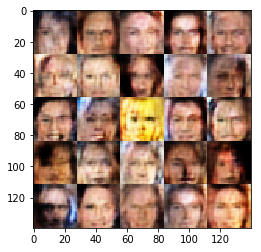

Epoch 1/1... Discriminator Loss: 0.1697... Generator Loss: 3.5535
Epoch 1/1... Discriminator Loss: 0.0795... Generator Loss: 3.1574
Epoch 1/1... Discriminator Loss: 2.0966... Generator Loss: 0.2525
Epoch 1/1... Discriminator Loss: 1.5664... Generator Loss: 3.8962
Epoch 1/1... Discriminator Loss: 1.1276... Generator Loss: 0.6255
Epoch 1/1... Discriminator Loss: 0.7037... Generator Loss: 1.0904
Epoch 1/1... Discriminator Loss: 1.5320... Generator Loss: 3.1271
Epoch 1/1... Discriminator Loss: 0.5946... Generator Loss: 3.0807
Epoch 1/1... Discriminator Loss: 2.0711... Generator Loss: 0.2735
Epoch 1/1... Discriminator Loss: 0.5242... Generator Loss: 1.0798


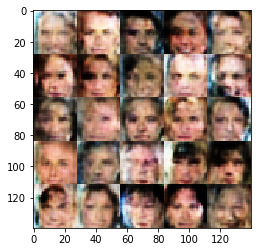

Epoch 1/1... Discriminator Loss: 0.1752... Generator Loss: 3.3699
Epoch 1/1... Discriminator Loss: 0.8645... Generator Loss: 6.4166
Epoch 1/1... Discriminator Loss: 1.0479... Generator Loss: 0.8118
Epoch 1/1... Discriminator Loss: 1.2855... Generator Loss: 3.0041
Epoch 1/1... Discriminator Loss: 0.7182... Generator Loss: 2.3492
Epoch 1/1... Discriminator Loss: 0.2223... Generator Loss: 2.6207
Epoch 1/1... Discriminator Loss: 0.7136... Generator Loss: 3.5820
Epoch 1/1... Discriminator Loss: 1.3081... Generator Loss: 0.4328
Epoch 1/1... Discriminator Loss: 1.3397... Generator Loss: 1.7780
Epoch 1/1... Discriminator Loss: 0.5517... Generator Loss: 1.7333


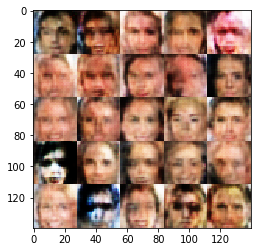

Epoch 1/1... Discriminator Loss: 0.6051... Generator Loss: 2.3525
Epoch 1/1... Discriminator Loss: 1.3943... Generator Loss: 0.4610
Epoch 1/1... Discriminator Loss: 1.0728... Generator Loss: 0.7491
Epoch 1/1... Discriminator Loss: 1.2615... Generator Loss: 0.5207
Epoch 1/1... Discriminator Loss: 0.4469... Generator Loss: 3.3126
Epoch 1/1... Discriminator Loss: 0.7133... Generator Loss: 2.4113
Epoch 1/1... Discriminator Loss: 0.8502... Generator Loss: 3.6415
Epoch 1/1... Discriminator Loss: 0.3896... Generator Loss: 1.9971
Epoch 1/1... Discriminator Loss: 0.1970... Generator Loss: 2.4033
Epoch 1/1... Discriminator Loss: 0.3765... Generator Loss: 1.5460


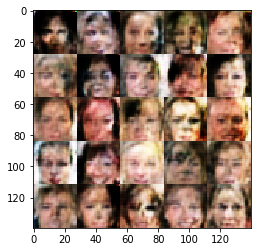

Epoch 1/1... Discriminator Loss: 0.6135... Generator Loss: 1.7619
Epoch 1/1... Discriminator Loss: 0.3675... Generator Loss: 1.5951
Epoch 1/1... Discriminator Loss: 0.9997... Generator Loss: 3.1581
Epoch 1/1... Discriminator Loss: 0.8198... Generator Loss: 1.1491
Epoch 1/1... Discriminator Loss: 0.7253... Generator Loss: 1.3143
Epoch 1/1... Discriminator Loss: 0.0823... Generator Loss: 3.6398
Epoch 1/1... Discriminator Loss: 1.0812... Generator Loss: 2.7348
Epoch 1/1... Discriminator Loss: 0.0739... Generator Loss: 3.7412
Epoch 1/1... Discriminator Loss: 0.8405... Generator Loss: 1.8988
Epoch 1/1... Discriminator Loss: 0.5900... Generator Loss: 2.0357


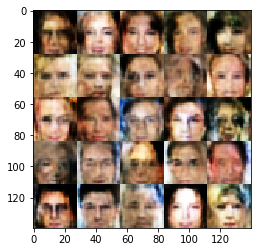

Epoch 1/1... Discriminator Loss: 0.7983... Generator Loss: 1.7171
Epoch 1/1... Discriminator Loss: 1.3385... Generator Loss: 0.5556
Epoch 1/1... Discriminator Loss: 0.2207... Generator Loss: 2.6335
Epoch 1/1... Discriminator Loss: 0.2677... Generator Loss: 1.9247
Epoch 1/1... Discriminator Loss: 0.1109... Generator Loss: 3.1652
Epoch 1/1... Discriminator Loss: 0.8095... Generator Loss: 1.0303
Epoch 1/1... Discriminator Loss: 1.1213... Generator Loss: 0.6675
Epoch 1/1... Discriminator Loss: 0.0819... Generator Loss: 3.1600
Epoch 1/1... Discriminator Loss: 2.5151... Generator Loss: 0.1949
Epoch 1/1... Discriminator Loss: 0.5846... Generator Loss: 1.1173


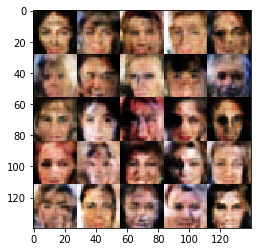

Epoch 1/1... Discriminator Loss: 0.6476... Generator Loss: 1.5585
Epoch 1/1... Discriminator Loss: 1.2371... Generator Loss: 0.7086
Epoch 1/1... Discriminator Loss: 0.4797... Generator Loss: 1.4679
Epoch 1/1... Discriminator Loss: 0.4686... Generator Loss: 2.3484
Epoch 1/1... Discriminator Loss: 0.1752... Generator Loss: 2.6634
Epoch 1/1... Discriminator Loss: 0.0918... Generator Loss: 5.1176
Epoch 1/1... Discriminator Loss: 0.1722... Generator Loss: 5.8250
Epoch 1/1... Discriminator Loss: 0.1515... Generator Loss: 2.4950
Epoch 1/1... Discriminator Loss: 0.5174... Generator Loss: 1.6139
Epoch 1/1... Discriminator Loss: 0.4869... Generator Loss: 2.1195


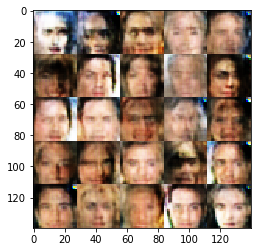

Epoch 1/1... Discriminator Loss: 0.8480... Generator Loss: 1.0333
Epoch 1/1... Discriminator Loss: 0.6986... Generator Loss: 2.7680
Epoch 1/1... Discriminator Loss: 1.0069... Generator Loss: 0.7120
Epoch 1/1... Discriminator Loss: 0.5262... Generator Loss: 1.4090
Epoch 1/1... Discriminator Loss: 1.0497... Generator Loss: 0.6535
Epoch 1/1... Discriminator Loss: 1.0585... Generator Loss: 2.4511
Epoch 1/1... Discriminator Loss: 0.8557... Generator Loss: 0.9020
Epoch 1/1... Discriminator Loss: 0.3341... Generator Loss: 1.8913
Epoch 1/1... Discriminator Loss: 1.0932... Generator Loss: 0.8325
Epoch 1/1... Discriminator Loss: 0.4404... Generator Loss: 3.6998


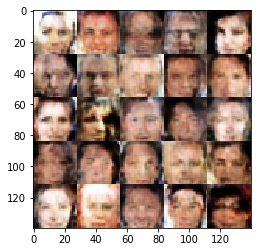

Epoch 1/1... Discriminator Loss: 0.2031... Generator Loss: 2.2857
Epoch 1/1... Discriminator Loss: 0.1509... Generator Loss: 3.2332
Epoch 1/1... Discriminator Loss: 0.2776... Generator Loss: 1.8938
Epoch 1/1... Discriminator Loss: 0.3490... Generator Loss: 2.9606
Epoch 1/1... Discriminator Loss: 0.6923... Generator Loss: 2.6189
Epoch 1/1... Discriminator Loss: 0.3044... Generator Loss: 2.4001
Epoch 1/1... Discriminator Loss: 0.9048... Generator Loss: 1.0277
Epoch 1/1... Discriminator Loss: 0.5391... Generator Loss: 1.2728
Epoch 1/1... Discriminator Loss: 0.7219... Generator Loss: 1.3014
Epoch 1/1... Discriminator Loss: 0.1232... Generator Loss: 3.3376


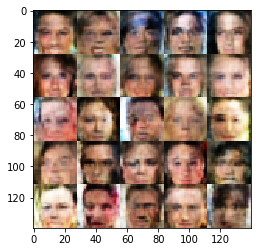

Epoch 1/1... Discriminator Loss: 0.0936... Generator Loss: 3.4111
Epoch 1/1... Discriminator Loss: 1.6451... Generator Loss: 6.2244
Epoch 1/1... Discriminator Loss: 0.5640... Generator Loss: 1.5299
Epoch 1/1... Discriminator Loss: 0.6366... Generator Loss: 1.2710
Epoch 1/1... Discriminator Loss: 0.3734... Generator Loss: 1.7049
Epoch 1/1... Discriminator Loss: 0.5072... Generator Loss: 4.0142
Epoch 1/1... Discriminator Loss: 1.4846... Generator Loss: 4.5572
Epoch 1/1... Discriminator Loss: 0.3185... Generator Loss: 2.0667
Epoch 1/1... Discriminator Loss: 0.1675... Generator Loss: 3.1974
Epoch 1/1... Discriminator Loss: 0.6951... Generator Loss: 3.9345


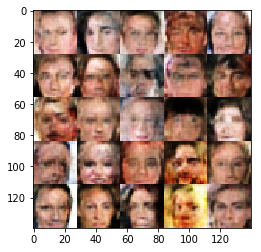

Epoch 1/1... Discriminator Loss: 1.0843... Generator Loss: 0.6415
Epoch 1/1... Discriminator Loss: 1.0512... Generator Loss: 0.6581
Epoch 1/1... Discriminator Loss: 0.1078... Generator Loss: 3.5666
Epoch 1/1... Discriminator Loss: 0.1202... Generator Loss: 4.1560
Epoch 1/1... Discriminator Loss: 0.9637... Generator Loss: 0.8593
Epoch 1/1... Discriminator Loss: 1.0146... Generator Loss: 1.0171
Epoch 1/1... Discriminator Loss: 0.6465... Generator Loss: 1.9321
Epoch 1/1... Discriminator Loss: 1.6240... Generator Loss: 0.3612
Epoch 1/1... Discriminator Loss: 0.3979... Generator Loss: 3.8313
Epoch 1/1... Discriminator Loss: 0.0735... Generator Loss: 4.1068


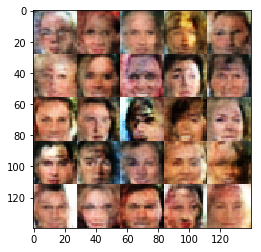

Epoch 1/1... Discriminator Loss: 0.3138... Generator Loss: 4.3601
Epoch 1/1... Discriminator Loss: 0.4008... Generator Loss: 1.6622
Epoch 1/1... Discriminator Loss: 0.2922... Generator Loss: 2.5798
Epoch 1/1... Discriminator Loss: 0.7429... Generator Loss: 3.0592
Epoch 1/1... Discriminator Loss: 0.3765... Generator Loss: 1.8180
Epoch 1/1... Discriminator Loss: 0.8674... Generator Loss: 2.4124
Epoch 1/1... Discriminator Loss: 1.5861... Generator Loss: 0.5217
Epoch 1/1... Discriminator Loss: 0.1725... Generator Loss: 5.7674
Epoch 1/1... Discriminator Loss: 0.5827... Generator Loss: 1.2437
Epoch 1/1... Discriminator Loss: 0.6953... Generator Loss: 1.0481


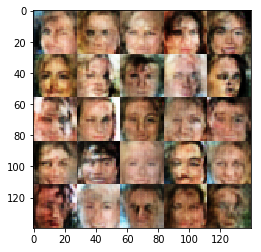

Epoch 1/1... Discriminator Loss: 0.1112... Generator Loss: 4.1223
Epoch 1/1... Discriminator Loss: 0.2075... Generator Loss: 2.8522
Epoch 1/1... Discriminator Loss: 0.7145... Generator Loss: 1.8660
Epoch 1/1... Discriminator Loss: 0.2026... Generator Loss: 3.2363
Epoch 1/1... Discriminator Loss: 0.2227... Generator Loss: 2.4913
Epoch 1/1... Discriminator Loss: 0.2611... Generator Loss: 4.2041
Epoch 1/1... Discriminator Loss: 0.1874... Generator Loss: 3.4835
Epoch 1/1... Discriminator Loss: 0.6174... Generator Loss: 1.3524
Epoch 1/1... Discriminator Loss: 0.6083... Generator Loss: 1.1063
Epoch 1/1... Discriminator Loss: 0.6524... Generator Loss: 4.0866


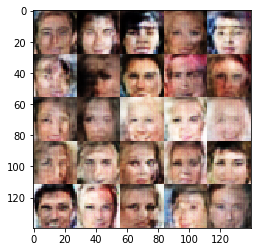

Epoch 1/1... Discriminator Loss: 0.3400... Generator Loss: 2.0724
Epoch 1/1... Discriminator Loss: 0.0892... Generator Loss: 4.3736
Epoch 1/1... Discriminator Loss: 0.2435... Generator Loss: 2.3987
Epoch 1/1... Discriminator Loss: 0.0552... Generator Loss: 4.4299
Epoch 1/1... Discriminator Loss: 0.0574... Generator Loss: 4.4117
Epoch 1/1... Discriminator Loss: 0.1211... Generator Loss: 2.8095
Epoch 1/1... Discriminator Loss: 0.6102... Generator Loss: 1.8296
Epoch 1/1... Discriminator Loss: 0.4962... Generator Loss: 2.1963
Epoch 1/1... Discriminator Loss: 0.3433... Generator Loss: 2.0297
Epoch 1/1... Discriminator Loss: 0.3640... Generator Loss: 2.7311


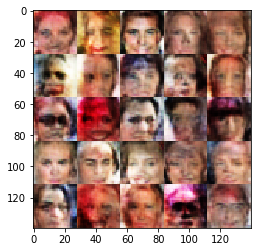

Epoch 1/1... Discriminator Loss: 0.5270... Generator Loss: 1.6173
Epoch 1/1... Discriminator Loss: 0.3809... Generator Loss: 1.8256
Epoch 1/1... Discriminator Loss: 0.1771... Generator Loss: 2.6791


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。